<a href="https://colab.research.google.com/github/raphael-fawaz/Financial-Markets-Analysis-and-Prediction/blob/LSTM-Variations-on-DJ%2CNASDAQ%2CEGX30/Stacked_Bi_LSTM_(EGX30)_Close_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stacked Bidirectinal LSTM (EGX30) - Close Price

In [1]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from pandas.plotting import lag_plot

In [3]:
EGX30 = pd.read_csv('EGX 30 Data June.csv',parse_dates=['Date'])

In [4]:
EGX30.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-06-05,"26,634.30","26,915.46","26,915.46","26,245.33",240.86M,-1.26%
1,2024-06-04,"26,973.00","26,852.33","27,158.65","26,852.33",352.59M,0.52%
2,2024-06-03,"26,834.47","26,869.85","27,003.04","26,760.84",267.86M,-0.13%
3,2024-06-02,"26,869.85","26,922.76","27,140.20","26,753.70",225.28M,-0.20%
4,2024-05-30,"26,922.76","27,089.68","27,116.25","26,683.97",352.59M,-0.62%


## Data engineering

In [5]:
def convert_volume_to_float(volume_str):
    if pd.isna(volume_str):
        return np.nan
    else:
        return float(volume_str[:-1]) * 1e6

def convert_change_to_float(change_str):
    if pd.isna(change_str):
        return np.nan
    else:
        return float(change_str[:-1]) /100

In [6]:
EGX30['Date'] = pd.to_datetime(EGX30['Date'])

EGX30 = EGX30.dropna()

num_cols = ['Price', 'Open', 'High', 'Low']
for col in num_cols:
    EGX30[col] = EGX30[col].str.replace(',', '').astype(float)

EGX30['Vol.'] = EGX30['Vol.'].apply(convert_volume_to_float)
EGX30['Change %']= EGX30['Change %'].apply(convert_change_to_float)

# Set the 'Date' column as the index
EGX30.set_index('Date', inplace=True)

#Change the name of the price column to close.
EGX30.rename(columns={'Price': 'Close'}, inplace=True)

EGX30 = EGX30[::-1]

EGX30.head()

<ipython-input-6-1def766975a1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EGX30[col] = EGX30[col].str.replace(',', '').astype(float)
<ipython-input-6-1def766975a1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EGX30[col] = EGX30[col].str.replace(',', '').astype(float)
<ipython-input-6-1def766975a1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

,Close,Open,High,Low,Vol.,Change %
Date,,,,,,
2009-03-01,3647.02,3597.56,3648.15,3588.01,43850000.0,0.0137
2009-03-02,3584.86,3640.55,3641.19,3584.86,46910000.0,-0.0170
2009-03-03,3517.33,3524.81,3533.41,3494.95,57010000.0,-0.0188
2009-03-04,3559.09,3524.63,3562.48,3524.63,68900000.0,0.0119
2009-03-05,3575.93,3566.55,3605.23,3565.60,54810000.0,0.0047


## Normalizing

In [7]:
egx30_close = EGX30['Close'].values.reshape(-1, 1)
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
egx30_close_scaled = scaler.fit_transform(egx30_close)

## Creating sequence

In [8]:
# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

In [9]:
seq_length = 60  # Use 60 days of data to predict the next day's price
egx30_sequences, egx30_labels = create_sequences(egx30_close_scaled, seq_length)

In [10]:
# Determine the index to split the data for the test set (last 60 days)
test_size = 60
train_sequences = egx30_sequences[:-test_size]
test_sequences = egx30_sequences[-test_size:]
train_labels = egx30_labels[:-test_size]
test_labels = egx30_labels[-test_size:]

## Stacked bidirectional lstm

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Bidirectional

In [12]:
regressor = Sequential()

regressor.add(Bidirectional(LSTM(units = 50, return_sequences = True, input_shape = (train_sequences.shape[1], 1))))
regressor.add(Dropout(0.2))

regressor.add(Bidirectional(LSTM(units = 50, return_sequences = True)))
regressor.add(Dropout(0.2))

regressor.add(Bidirectional(LSTM(units = 50)))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(train_sequences, train_labels, epochs = 100, batch_size = 32)

Epoch 1/100
112/112 [==============================] - 18s 28ms/step - loss: 0.0029
Epoch 2/100
112/112 [==============================] - 2s 19ms/step - loss: 7.7333e-04
Epoch 3/100
112/112 [==============================] - 2s 19ms/step - loss: 6.2134e-04
Epoch 4/100
112/112 [==============================] - 2s 20ms/step - loss: 6.0441e-04
Epoch 5/100
112/112 [==============================] - 2s 19ms/step - loss: 5.9817e-04
Epoch 6/100
112/112 [==============================] - 2s 22ms/step - loss: 5.3006e-04
Epoch 7/100
112/112 [==============================] - 3s 24ms/step - loss: 5.5696e-04
Epoch 8/100
112/112 [==============================] - 2s 19ms/step - loss: 4.1921e-04
Epoch 9/100
112/112 [==============================] - 2s 20ms/step - loss: 4.7358e-04
Epoch 10/100
112/112 [==============================] - 2s 19ms/step - loss: 5.1847e-04
Epoch 11/100
112/112 [==============================] - 2s 19ms/step - loss: 4.2702e-04
Epoch 12/100
112/112 [======================

## Evaluate prediction

In [13]:
predicted_stock_price_egx30 = regressor.predict(test_sequences)
# predicted_stock_price = sc.inverse_transform(predicted_stock_price)
#real_price = sc.inverse_transform(test_labels_nasdaq)

2/2 [==============================] - 2s 12ms/step


In [14]:
rmse = np.sqrt(mean_squared_error(test_labels, predicted_stock_price_egx30))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.03389823137660671


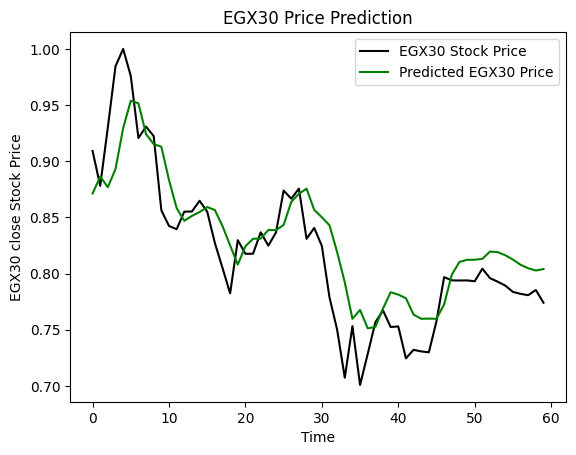

In [15]:
plt.plot(test_labels, color = 'black', label = 'EGX30 Stock Price')
plt.plot(predicted_stock_price_egx30, color = 'green', label = 'Predicted EGX30 Price')
plt.title('EGX30 Price Prediction')
plt.xlabel('Time')
plt.ylabel('EGX30 close Stock Price')
plt.legend()
plt.show()

## Next 30 days prediction

1/1 [==============================] - 0s 22ms/step
Predicted EGX30 Prices for the Next 30 Days:
2024-06-06: 27375.64
2024-06-07: 27627.47
2024-06-08: 27940.31
2024-06-09: 28214.62
2024-06-10: 28424.04
2024-06-11: 28577.65
2024-06-12: 28691.44
2024-06-13: 28786.31
2024-06-14: 28845.67
2024-06-15: 28874.66
2024-06-16: 28907.24
2024-06-17: 28946.04
2024-06-18: 28997.46
2024-06-19: 29054.03
2024-06-20: 29112.83
2024-06-21: 29159.58
2024-06-22: 29190.42
2024-06-23: 29209.59
2024-06-24: 29219.98
2024-06-25: 29230.05
2024-06-26: 29215.02
2024-06-27: 29193.08
2024-06-28: 29167.74
2024-06-29: 29138.93
2024-06-30: 29125.23
2024-07-01: 29125.11
2024-07-02: 29123.84
2024-07-03: 29127.04
2024-07-04: 29120.03
2024-07-05: 29117.60


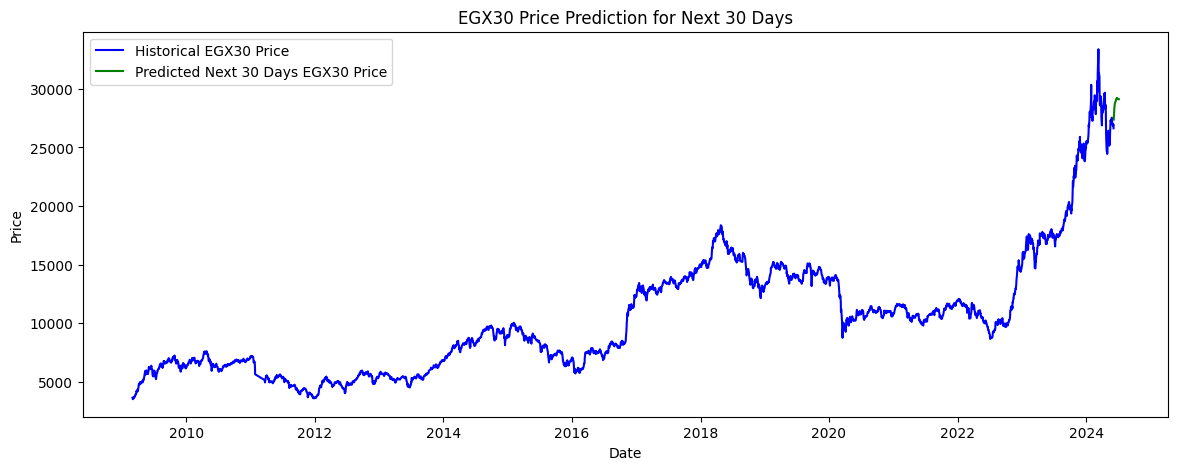

In [16]:
# Predict the next 30 days
last_sequence = egx30_close_scaled[-seq_length:]  # Last 60 days
next_30_days = []

for _ in range(30):
    next_day_pred = regressor.predict(last_sequence.reshape(1, seq_length, 1))
    next_30_days.append(next_day_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_day_pred)

# Inverse transform the predictions
next_30_days = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1))

# Create a date range for the next 30 days
last_date = EGX30.index[-1]
next_dates = pd.date_range(start=last_date, periods=30) + pd.DateOffset(days=1)

print("Predicted EGX30 Prices for the Next 30 Days:")
for date, price in zip(next_dates, next_30_days):
    print(f"{date.date()}: {price[0]:.2f}")

# Plot the next 30 days predictions
plt.figure(figsize=(14, 5))
plt.plot(EGX30.index, egx30_close, color='blue', label='Historical EGX30 Price')
plt.plot(next_dates, next_30_days, color='green', label='Predicted Next 30 Days EGX30 Price')
plt.title('EGX30 Price Prediction for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()